<a href="https://colab.research.google.com/github/cityu-assignment/CS3481-assignment3/blob/main/cs3481_asm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

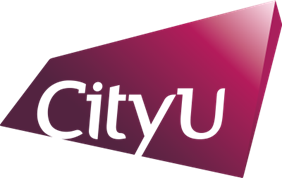

# **CS3481 Fundamentals of Data Science**

**Student Name: Lee Chak Kei**

**Student ID: 56682401**

# Import library

Importing necessary libraries then checks if the code is running in Google Colab and installs dtreeviz package silently, if it is.

In [356]:
import numpy as np 
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans

from matplotlib.pyplot import figure

# Data Processing

The code loads a dataset file column_3C_weka.arff using arff.loadarff() function from scipy.io module, and creates a Pandas DataFrame from the data.

In [357]:
from scipy.io import arff

data = arff.loadarff("/content/column_3C_weka.arff")
df = pd.DataFrame(data[0])
df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,b'Hernia'
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,b'Hernia'
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,b'Hernia'
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,b'Hernia'
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,b'Hernia'
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,b'Normal'
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,b'Normal'
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,b'Normal'
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,b'Normal'


The code converts the data type of the 'class' column to string, and removes the first character ('b') of each element of the column (b'Hernia').

In [358]:
df['class'] = df['class'].astype('string')
df['class'] = [i[2:-1] for i in df['class']]
df['class']

0      Hernia
1      Hernia
2      Hernia
3      Hernia
4      Hernia
        ...  
305    Normal
306    Normal
307    Normal
308    Normal
309    Normal
Name: class, Length: 310, dtype: object

In [359]:
columns = df.iloc[:,:6].columns
columns

Index(['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis'],
      dtype='object')

The code selects the first 6 columns of the DataFrame as the feature matrix X.

In [360]:
X = df.iloc[:,:6].values
X

array([[ 63.0278175 ,  22.55258597,  39.60911701,  40.47523153,
         98.67291675,  -0.25439999],
       [ 39.05695098,  10.06099147,  25.01537822,  28.99595951,
        114.4054254 ,   4.56425864],
       [ 68.83202098,  22.21848205,  50.09219357,  46.61353893,
        105.9851355 ,  -3.53031731],
       ...,
       [ 61.44659663,  22.6949683 ,  46.17034732,  38.75162833,
        125.6707246 ,  -2.70787952],
       [ 45.25279209,   8.69315736,  41.5831264 ,  36.55963472,
        118.5458418 ,   0.21475017],
       [ 33.84164075,   5.07399141,  36.64123294,  28.76764934,
        123.9452436 ,  -0.19924909]])

### Normalize the input attributes

In [361]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X

array([[0.35568788, 0.51989984, 0.22917997, 0.2508573 , 0.30746116,
        0.02514839],
       [0.12450104, 0.2967831 , 0.09857833, 0.14462935, 0.47664891,
        0.03636497],
       [0.41166648, 0.51393229, 0.32299466, 0.30766054, 0.38609692,
        0.0175229 ],
       ...,
       [0.34043781, 0.52244298, 0.28789745, 0.23490726, 0.59779618,
        0.01943732],
       [0.18425678, 0.27235174, 0.24684569, 0.21462279, 0.52117504,
        0.02624045],
       [0.07420202, 0.20770855, 0.20261992, 0.14251659, 0.57924032,
        0.02527676]])

### Detect and Remove the Outliers using Z-Score

In [362]:
z_score = np.abs(stats.zscore(X))

threshold = 3
X = X[(z_score < threshold).all(axis=1)]

298 samples with 6 dimensions

In [363]:
print(X.shape)

(298, 6)


# Global Variable

In [364]:
all_z = []
all_labels = []

# Def Function

In [365]:
np.set_printoptions(suppress=True)

# Method: 'single', 'complete', 'average
def constructClustering(data):
  for i in ['single', 'complete', 'average']:
      Z = linkage(data, i)

      print(i)
      print("="*30)

      print(Z[:200])

      plotClustering(Z)
      plotTruncatedClustering(Z)
      print("="*30)

      all_z.append(Z)

In [366]:
def plotClustering(Z):
  ax = plt.figure(figsize=(25, 10)).subplots()
  dendrogram(Z)
  plt.title('Hierarchical Clustering Dendrogram')
  plt.xlabel('sample index')
  plt.ylabel('distance')
  plt.show()

In [367]:
def plotTruncatedClustering(Z):
  ax = plt.figure(figsize=(25, 10)).subplots()
  
  dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
  )

  plt.title('Hierarchical Clustering Dendrogram (truncated)')
  plt.xlabel('sample index')
  plt.ylabel('distance')
  plt.show()

In [368]:
def extractClustering(data, K):
  names = ['single', 'complete', 'average']

  for i in range(3):
    kclusters = fcluster(all_z[i], K, criterion='maxclust')

    print("="*30)
    print(names[i])

    print(kclusters)
    all_labels.append(kclusters)

    fig, ax = plt.subplots()
    plt.scatter(data[:,0],data[:,1],c=kclusters)
    plt.show()

    print("="*30)

In [369]:
def constructKmeans(K):
  km = KMeans(n_clusters = K, random_state=0)
  km.fit(X)  
  y_kmeans = km.predict(X)
  print(km.labels_)

  all_labels.append(km.labels_)

  plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
  
  centers = km.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
  plt.show()

# Construct Hierarchical Clustering

single
[[244.         255.           0.02962708   2.        ]
 [280.         291.           0.03143675   2.        ]
 [  5.         250.           0.0327745    2.        ]
 [102.         232.           0.03425149   2.        ]
 [204.         288.           0.04068401   2.        ]
 [147.         210.           0.0413207    2.        ]
 [268.         293.           0.04177951   2.        ]
 [254.         296.           0.04263469   2.        ]
 [279.         304.           0.04278424   3.        ]
 [ 57.         234.           0.04332551   2.        ]
 [ 39.          50.           0.04411332   2.        ]
 [290.         294.           0.04546358   2.        ]
 [ 76.         166.           0.04591815   2.        ]
 [ 47.          54.           0.04607673   2.        ]
 [228.         260.           0.04658414   2.        ]
 [251.         299.           0.04729655   3.        ]
 [249.         276.           0.04767216   2.        ]
 [306.         307.           0.0489983    5.        ]
 [ 

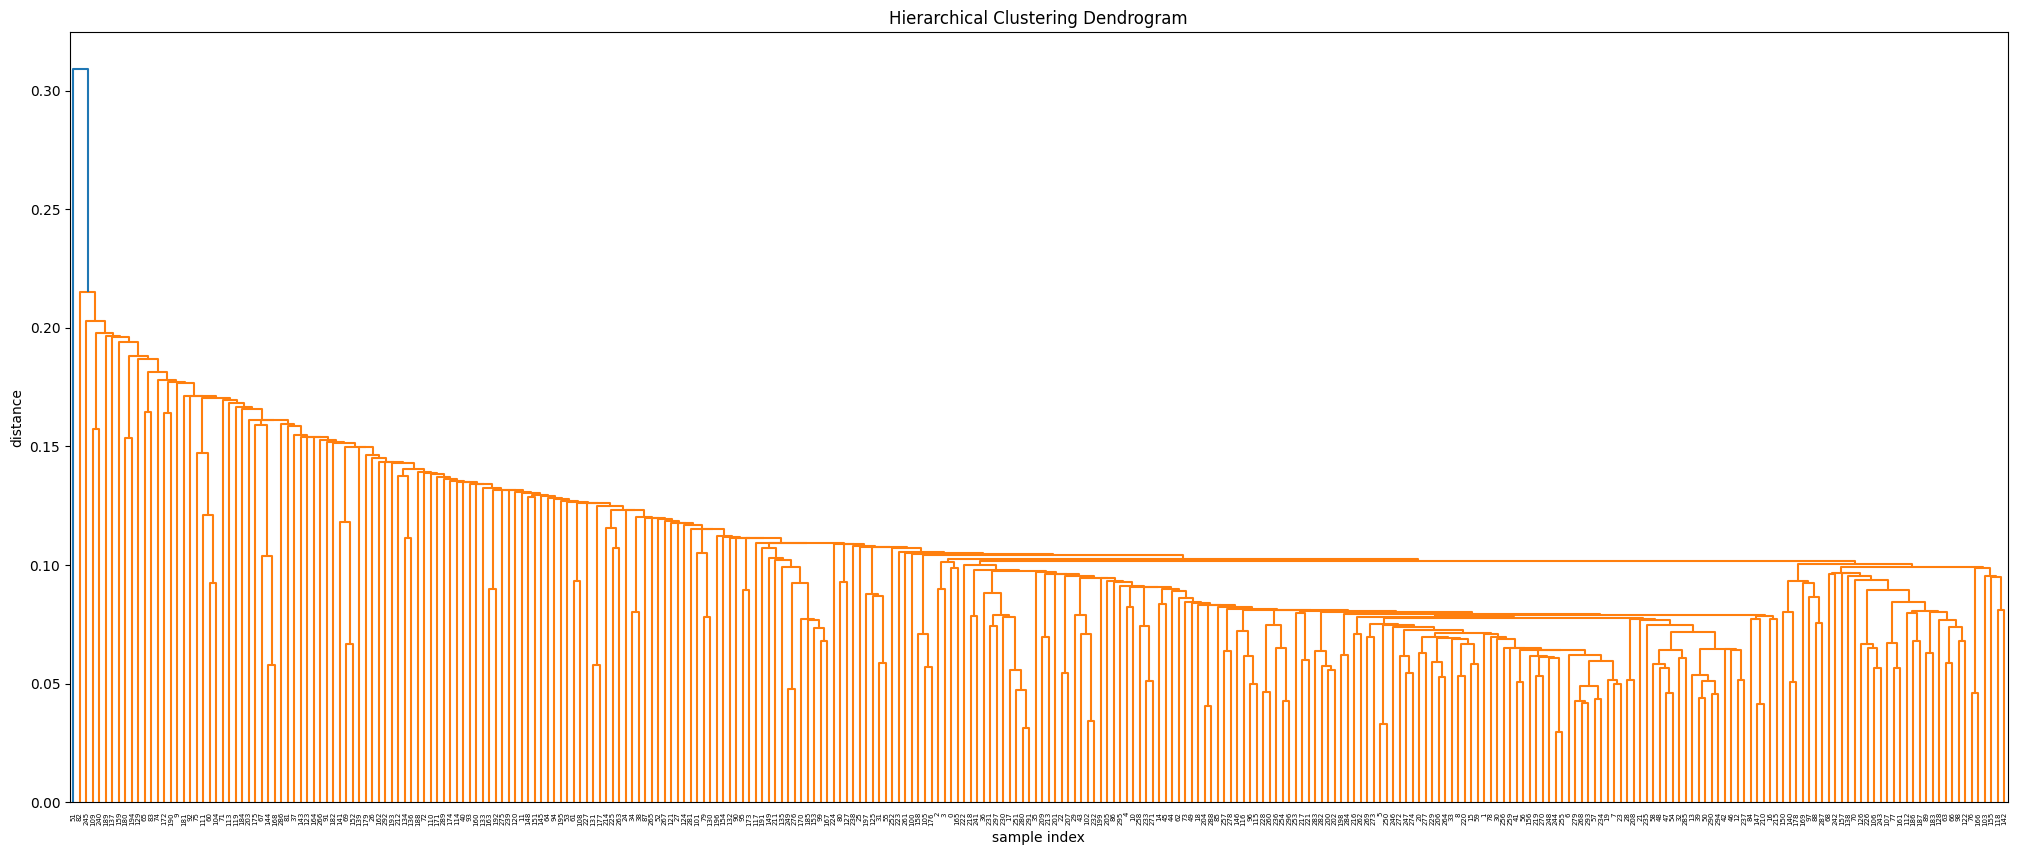

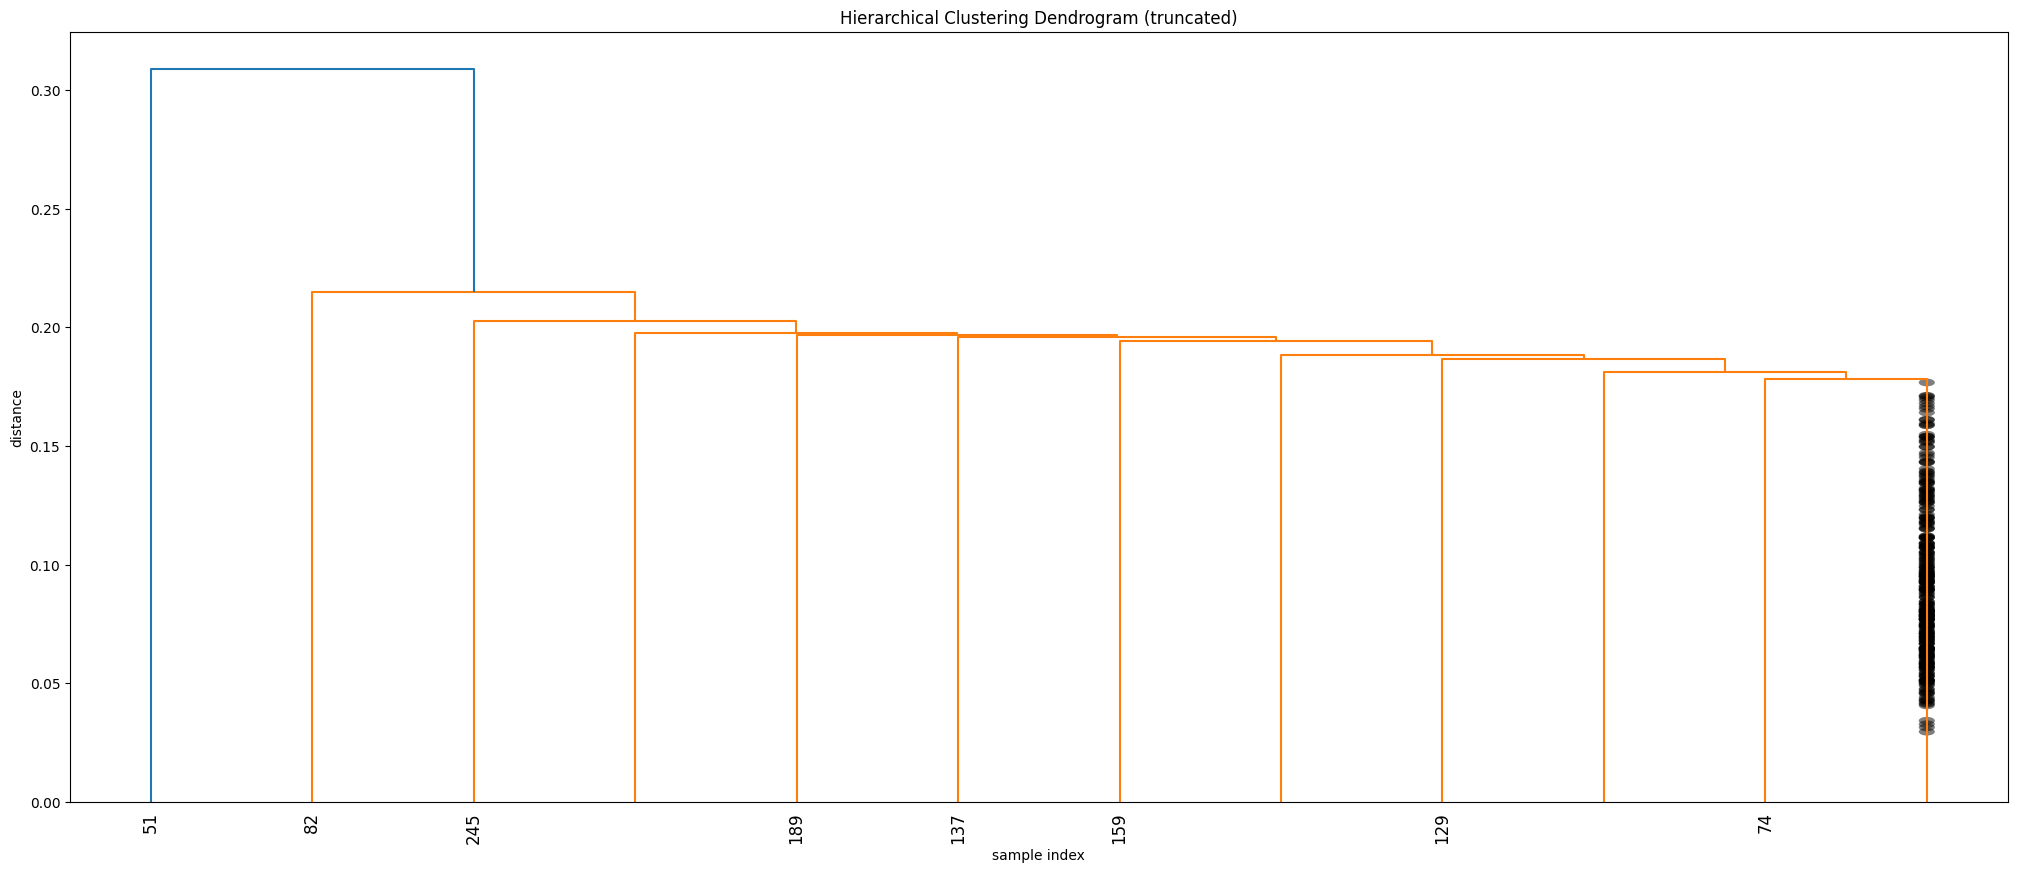

complete
[[244.         255.           0.02962708   2.        ]
 [280.         291.           0.03143675   2.        ]
 [  5.         250.           0.0327745    2.        ]
 [102.         232.           0.03425149   2.        ]
 [204.         288.           0.04068401   2.        ]
 [147.         210.           0.0413207    2.        ]
 [268.         293.           0.04177951   2.        ]
 [254.         296.           0.04263469   2.        ]
 [ 57.         234.           0.04332551   2.        ]
 [ 39.          50.           0.04411332   2.        ]
 [290.         294.           0.04546358   2.        ]
 [ 76.         166.           0.04591815   2.        ]
 [ 47.          54.           0.04607673   2.        ]
 [228.         260.           0.04658414   2.        ]
 [249.         276.           0.04767216   2.        ]
 [  7.          23.           0.04963999   2.        ]
 [ 96.         115.           0.04997506   2.        ]
 [140.         178.           0.0505204    2.        ]
 

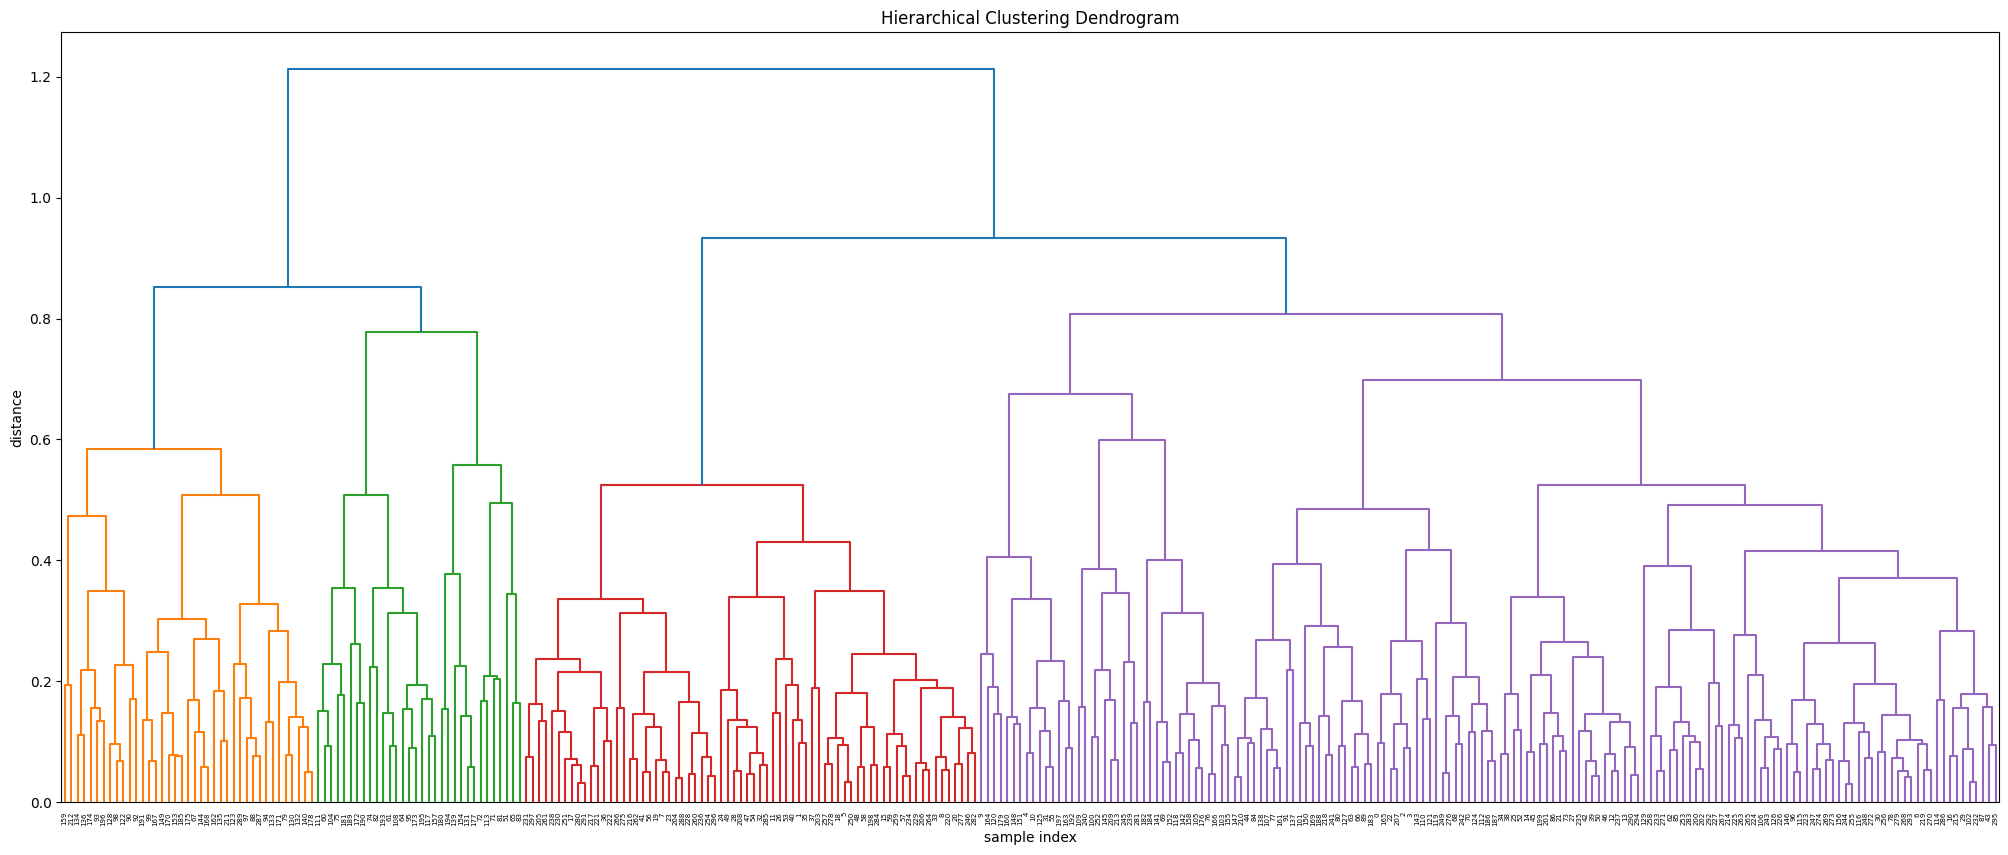

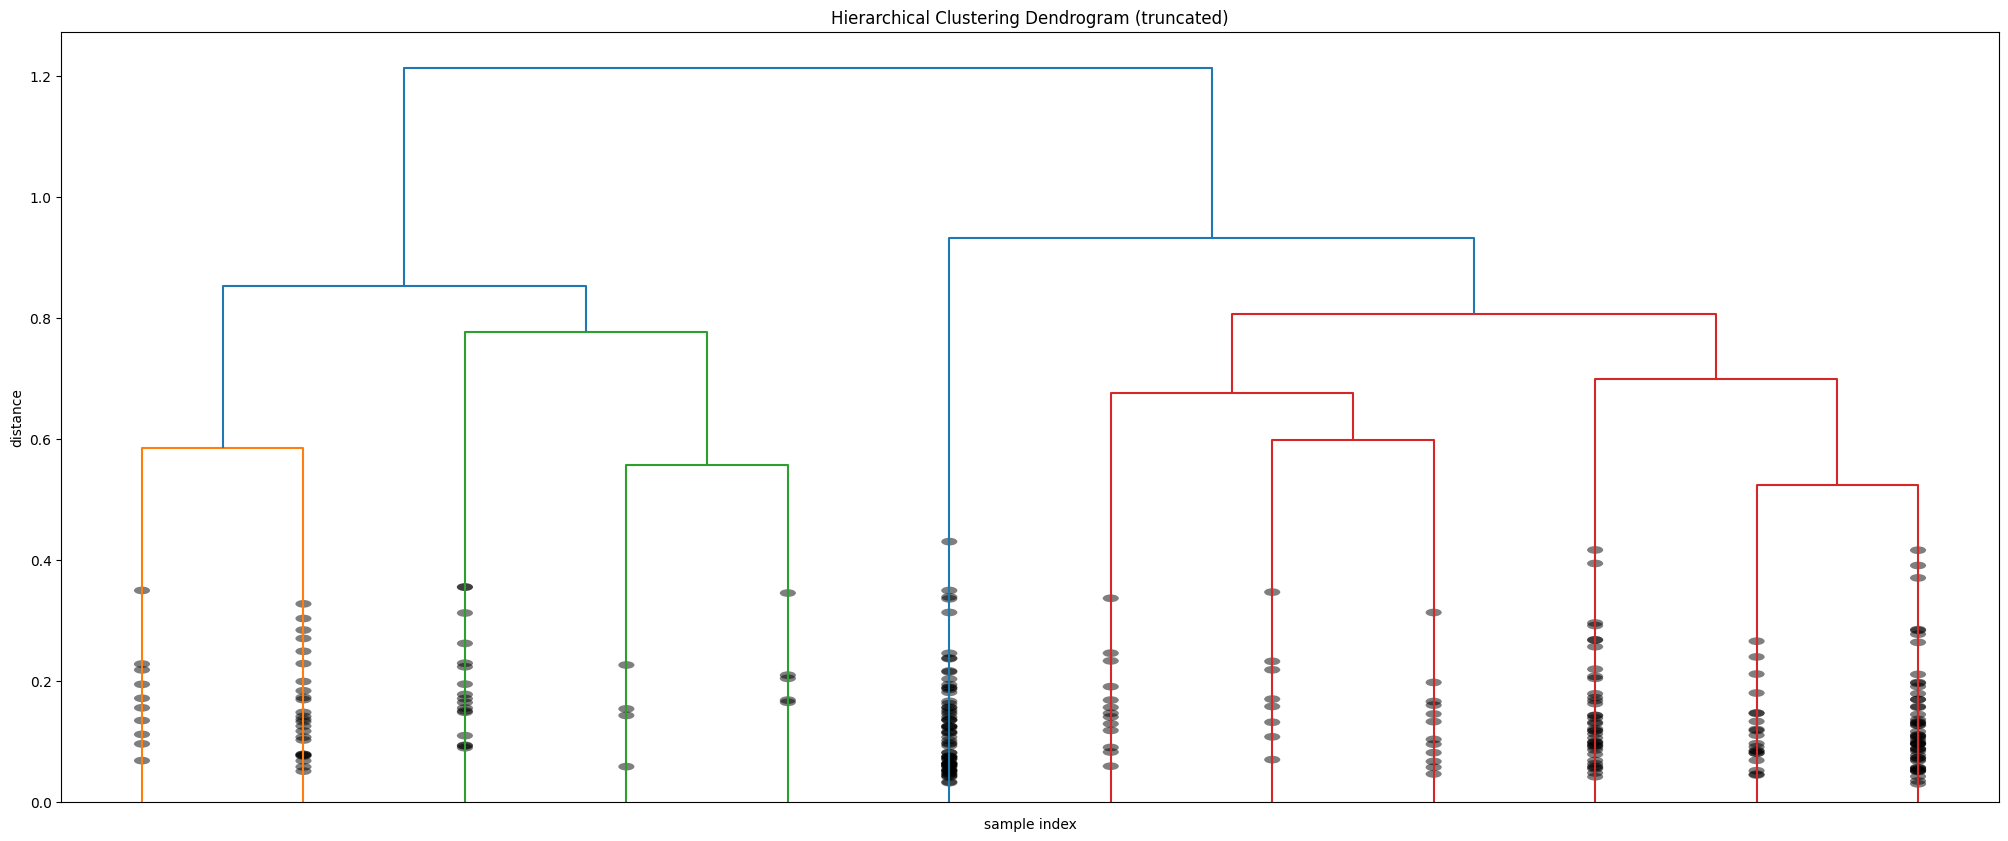

average
[[244.         255.           0.02962708   2.        ]
 [280.         291.           0.03143675   2.        ]
 [  5.         250.           0.0327745    2.        ]
 [102.         232.           0.03425149   2.        ]
 [204.         288.           0.04068401   2.        ]
 [147.         210.           0.0413207    2.        ]
 [268.         293.           0.04177951   2.        ]
 [254.         296.           0.04263469   2.        ]
 [ 57.         234.           0.04332551   2.        ]
 [ 39.          50.           0.04411332   2.        ]
 [290.         294.           0.04546358   2.        ]
 [ 76.         166.           0.04591815   2.        ]
 [ 47.          54.           0.04607673   2.        ]
 [228.         260.           0.04658414   2.        ]
 [279.         304.           0.04693131   3.        ]
 [249.         276.           0.04767216   2.        ]
 [  7.          23.           0.04963999   2.        ]
 [ 96.         115.           0.04997506   2.        ]
 [

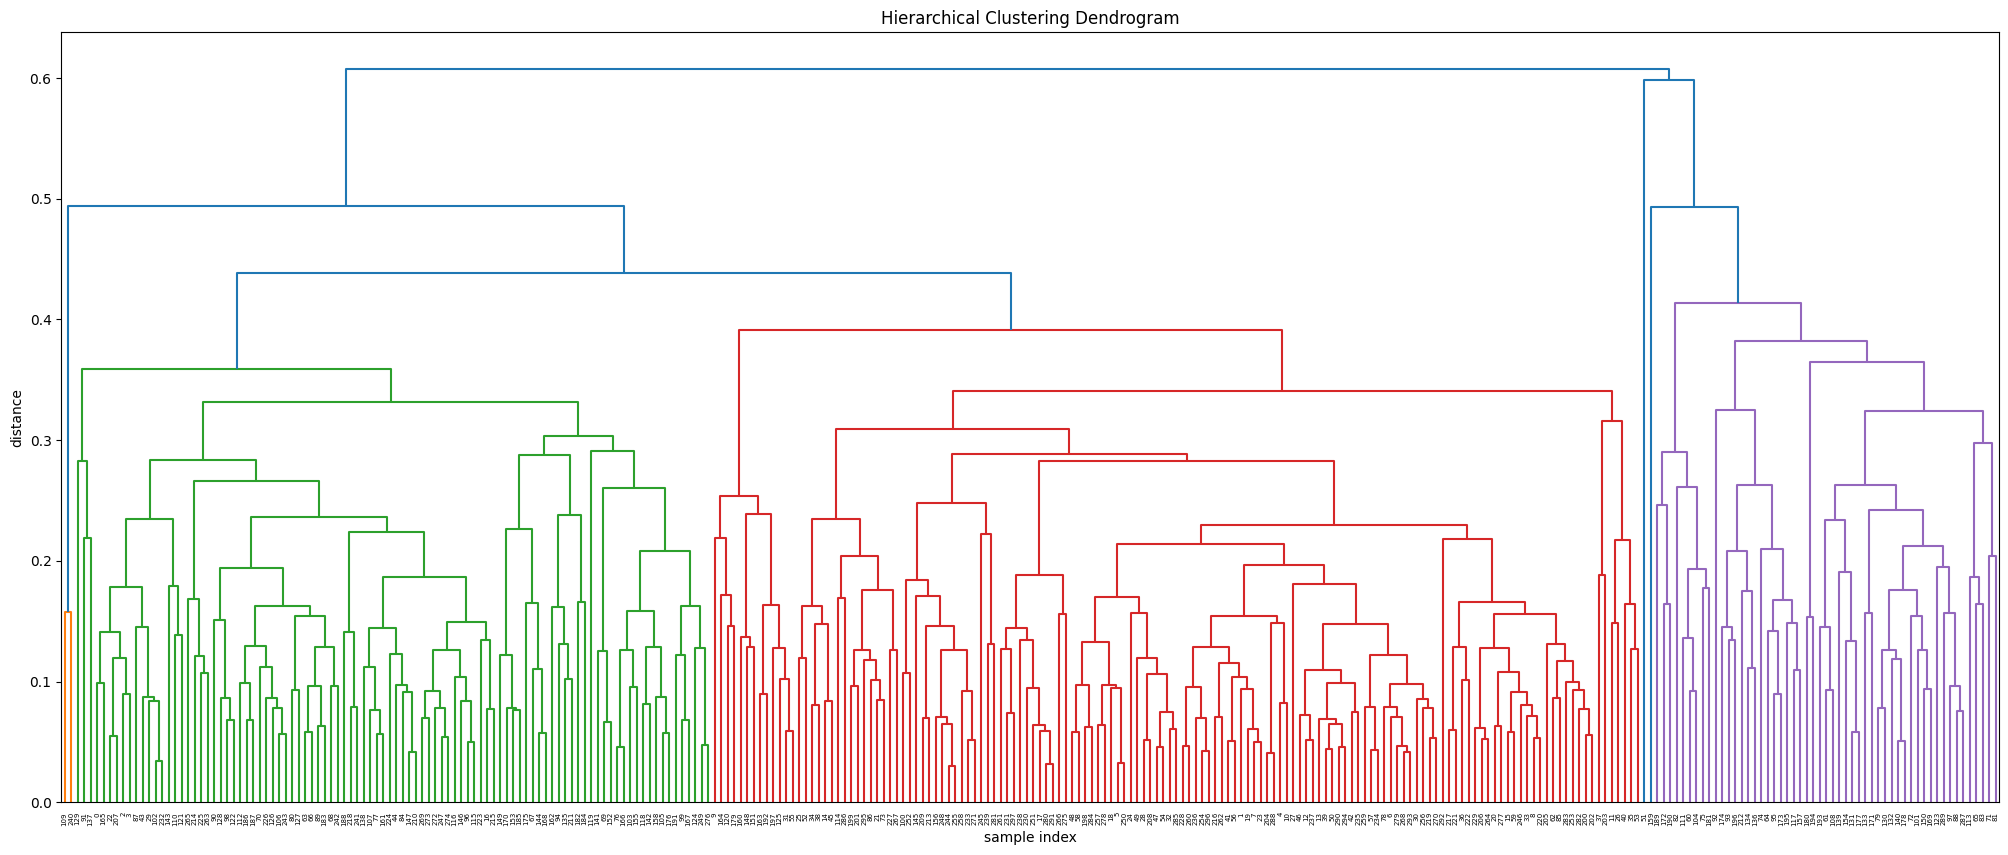

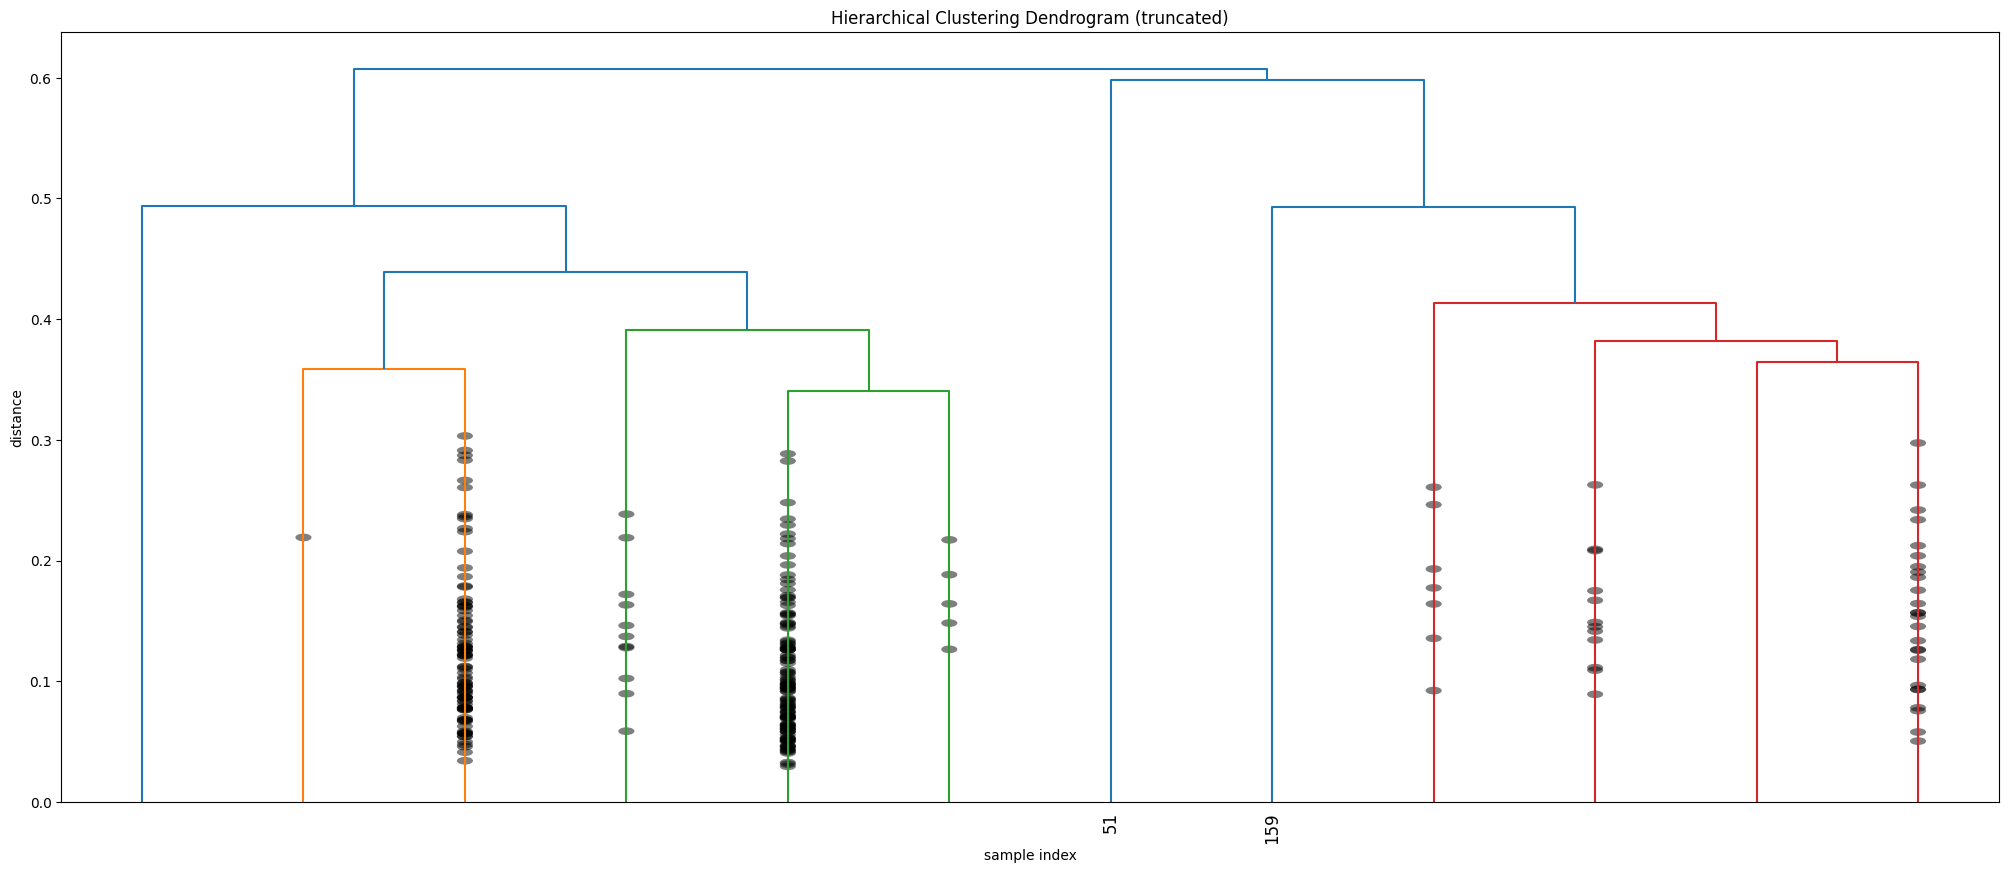

In [370]:
constructClustering(X)

Single Linkage tends to create long chains of clusters that follow the path of small distances. In the dendrogram, we can see that single linkage has created a long chain of clusters that goes from the top to the bottom of the graph. 

Complete Linkage clustering tends to form clusters that are more compact and spherical. In the dendrogram, we can see that complete linkage has formed more compact clusters than single linkage.

Group average clustering is a compromise between single linkage and complete linkage, as it tries to form clusters that are both compact and follow the path of small distances. In the dendrogram, we can see that group average clustering has formed clusters that are somewhat compact but also follow the path of small distances. 

Observing the set of distance values at which cluster merge occurs, it is clear that single link generates smaller distance values, complete link generates larger distance values, while group average generates moderate distance values. `In terms of the first cluster to merge, single link and group average both have cluster 2 and 3 merging at a relatively smaller distance value of 0.52 and 0.64, respectively, while complete link has them merging at a larger distance value of 0.94. For the second cluster to merge, single link has cluster 1 merging with the previous merged cluster at a distance of 1.05, while complete link has them merging at a larger distance of 1.13, and group average has them merging at a moderate distance of 1.03. Finally, all three methods have the same final cluster formed, which is the union of cluster 1 with the previously merged clusters 2 and 3, at respective distance values of 1.87, 2.23, and 1.79 for single link, complete link, and group average. The order in which clusters merge is consistent across all three methods: clusters 2 and 3 merge first, followed by the merging of cluster 1 with the previously merged cluster. Finally, the union of all three clusters forms the final cluster.`

# Different Clustering Solutions

single
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


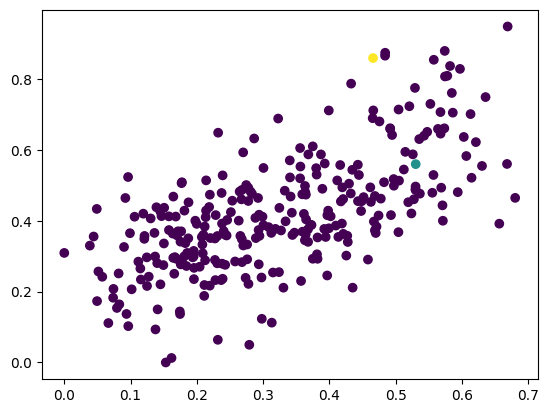

complete
[3 2 3 3 3 2 3 2 2 3 3 2 3 3 3 2 3 2 2 2 2 3 3 2 2 3 2 3 2 3 3 3 2 2 3 2 2
 2 3 3 2 2 3 3 3 3 3 2 2 2 3 1 3 2 2 3 2 2 2 2 1 1 3 3 1 1 3 1 3 3 3 1 1 3
 1 1 3 3 3 1 3 1 1 1 3 3 3 3 1 3 1 3 1 1 1 1 3 1 1 1 3 3 3 3 1 3 3 3 1 3 3
 1 3 1 3 3 3 1 3 3 3 3 1 1 3 3 3 3 1 3 1 1 1 1 1 1 1 3 3 1 1 3 3 3 1 3 3 3
 3 1 3 3 3 1 1 3 3 1 3 1 3 3 1 3 3 3 3 1 1 3 1 1 1 1 1 1 3 1 1 3 1 1 3 3 3
 1 3 3 3 1 1 1 3 1 1 1 1 3 2 3 3 3 3 2 2 2 2 3 2 3 3 1 1 3 3 3 2 2 3 3 2 2
 2 3 3 3 3 3 2 2 2 2 3 3 2 3 2 3 2 3 3 3 3 3 3 3 2 3 3 3 2 2 3 3 2 3 3 2 3
 2 2 2 2 3 2 3 2 3 3 3 3 3 3 3 3 2 3 2 2 3 2 3 2 3 2 2 3 1 2 1 3 2 3 3 3 3
 2 2]


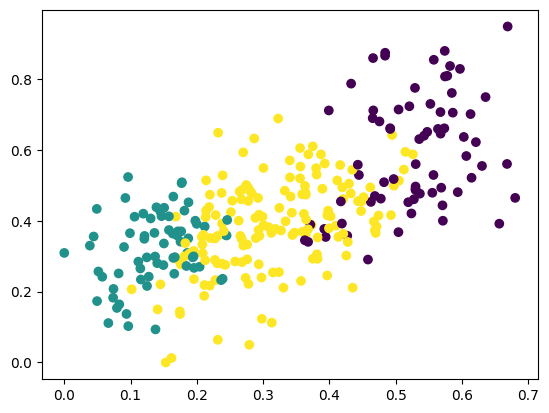

average
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 2 2 1 1 2 2 1 1 1 1 1 2 2 1
 2 2 1 1 1 2 1 2 2 2 1 1 1 1 2 1 1 1 2 2 1 2 1 2 1 1 1 2 1 1 2 1 1 1 2 1 1
 2 1 2 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 2 2 2 2 2 1 2 1 1 2 2 1 1 1 1 1 1 1
 1 1 2 1 1 1 2 1 1 2 1 2 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 1 2 2 1 2 2 1 1 1
 1 1 1 1 2 2 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1
 1 1]


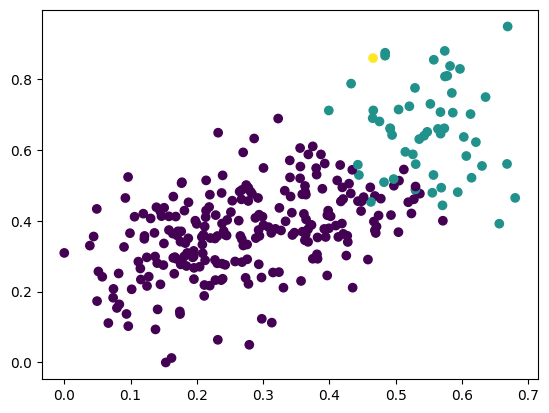

In [371]:
extractClustering(X, 3)

In the single linkage method, we can see that most observations are assigned to cluster 1, and a few observations are assigned to cluster 2 and 3. This is not an optimal result as it fails to identify the clear boundary between the two classes, assigning most of the data points to the same cluster.

In the complete linkage method, we can see that the observations are more evenly distributed across the clusters, with no single cluster dominating the others. This result is better than single link method.

The results of Group Average Clustering appear to be a vector with 298 elements, where each element represents the cluster assignment of the corresponding data point. The majority of the data points seem to be assigned to cluster 1, with a few data points assigned to clusters 2 and 3.

[2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 2 0 0 2 2 2 2 2 0 0 1
 0 0 2 2 1 0 2 0 0 0 2 1 1 2 0 2 0 2 0 0 0 0 2 0 2 2 2 0 2 2 0 2 2 2 0 2 2
 0 2 0 1 2 1 0 2 2 2 2 2 0 2 1 2 2 0 2 0 0 0 0 0 2 0 2 2 0 0 2 2 2 2 1 2 2
 1 2 0 1 2 2 0 2 1 0 2 0 1 2 2 2 2 2 2 2 2 0 2 0 0 0 0 0 2 0 0 2 0 0 2 2 2
 2 2 2 2 0 0 2 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 0 2 2 2 1 1 2 1 1 1
 1 2 2 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 2 1 1 1 2 1 2 1 1 2 1 1 1 1 1 1
 1 1 1 1 2 1 2 1 1 1 2 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


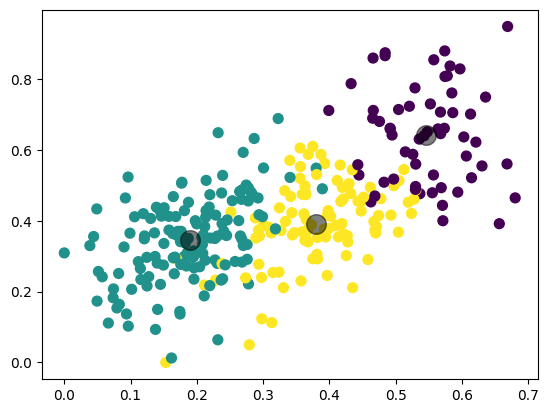

In [372]:
constructKmeans(3)

In the K-means method, it seems that the data points are fairly evenly distributed across the clusters. There does not appear to be a single cluster that dominates the others, which suggests that the algorithm has done a good job of separating the data into distinct groups. 

In conclusion, K-means and Complete link method can capture most of the class structure of the data set since both of the data points are fairly evenly distrubuted compare with the others method.

# Select different subsets of attributes

## Dimension Reduction PCA

In [374]:
from sklearn.decomposition import PCA

pca = PCA()
x_pca = pca.fit_transform(X)
x_pca = pd.DataFrame(x_pca)

x_pca['target']=df['class']
x_pca.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'target']
x_pca.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,target
0,0.007358,-0.013808,0.255242,0.025820,-0.037643,1.588691e-12,Hernia
1,-0.349717,-0.002972,0.088084,0.004643,0.028001,-2.698471e-13,Hernia
2,0.098776,-0.017974,0.145838,0.038083,-0.068380,-4.323783e-13,Hernia
3,0.096945,0.005486,0.221022,0.048777,-0.026713,-6.039965e-11,Hernia
4,-0.234453,-0.095885,0.113719,0.067317,0.022692,5.111910e-12,Hernia


In [375]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.5949352 , 0.20253916, 0.13582446, 0.05088033, 0.01582086,
       0.        ])

The output explained_variance is an array that shows the proportion of the variance in the original data that is explained by each principal component (PC) extracted by Principal Component Analysis (PCA). 

The first PC explains about 59.5% of the variance in the original data, the second PC explains about 20.25%, the third PC explains about 13.58%, the fourth PC explains about 5.09%, the fifth PC explains about 1.58%, and the sixth PC explains an extremely small amount of variance that is close to zero.

Therefore, we could try (`pelvic_incidence` and `sacral_slope`).

In [376]:
subset_attr = x_pca[['pelvic_incidence', 'sacral_slope']]

# Re-perform hierarchical clustering (subsets of attributes)

single
[[ 31.         296.           0.00112203   2.        ]
 [ 48.          54.           0.00241438   2.        ]
 [146.         247.           0.00249686   2.        ]
 [  8.         208.           0.00280528   2.        ]
 [116.         209.           0.00296044   2.        ]
 [ 40.         291.           0.00307445   2.        ]
 [ 34.          84.           0.00372801   2.        ]
 [  6.         219.           0.00383126   2.        ]
 [ 13.         270.           0.00387106   2.        ]
 [108.         140.           0.00433453   2.        ]
 [ 15.          20.           0.00466017   2.        ]
 [ 88.         169.           0.00488055   2.        ]
 [ 83.         162.           0.00496083   2.        ]
 [206.         229.           0.00511782   2.        ]
 [228.         246.           0.00521734   2.        ]
 [ 28.         220.           0.00538705   2.        ]
 [ 11.          17.           0.00548805   2.        ]
 [ 50.         302.           0.00565303   3.        ]
 [1

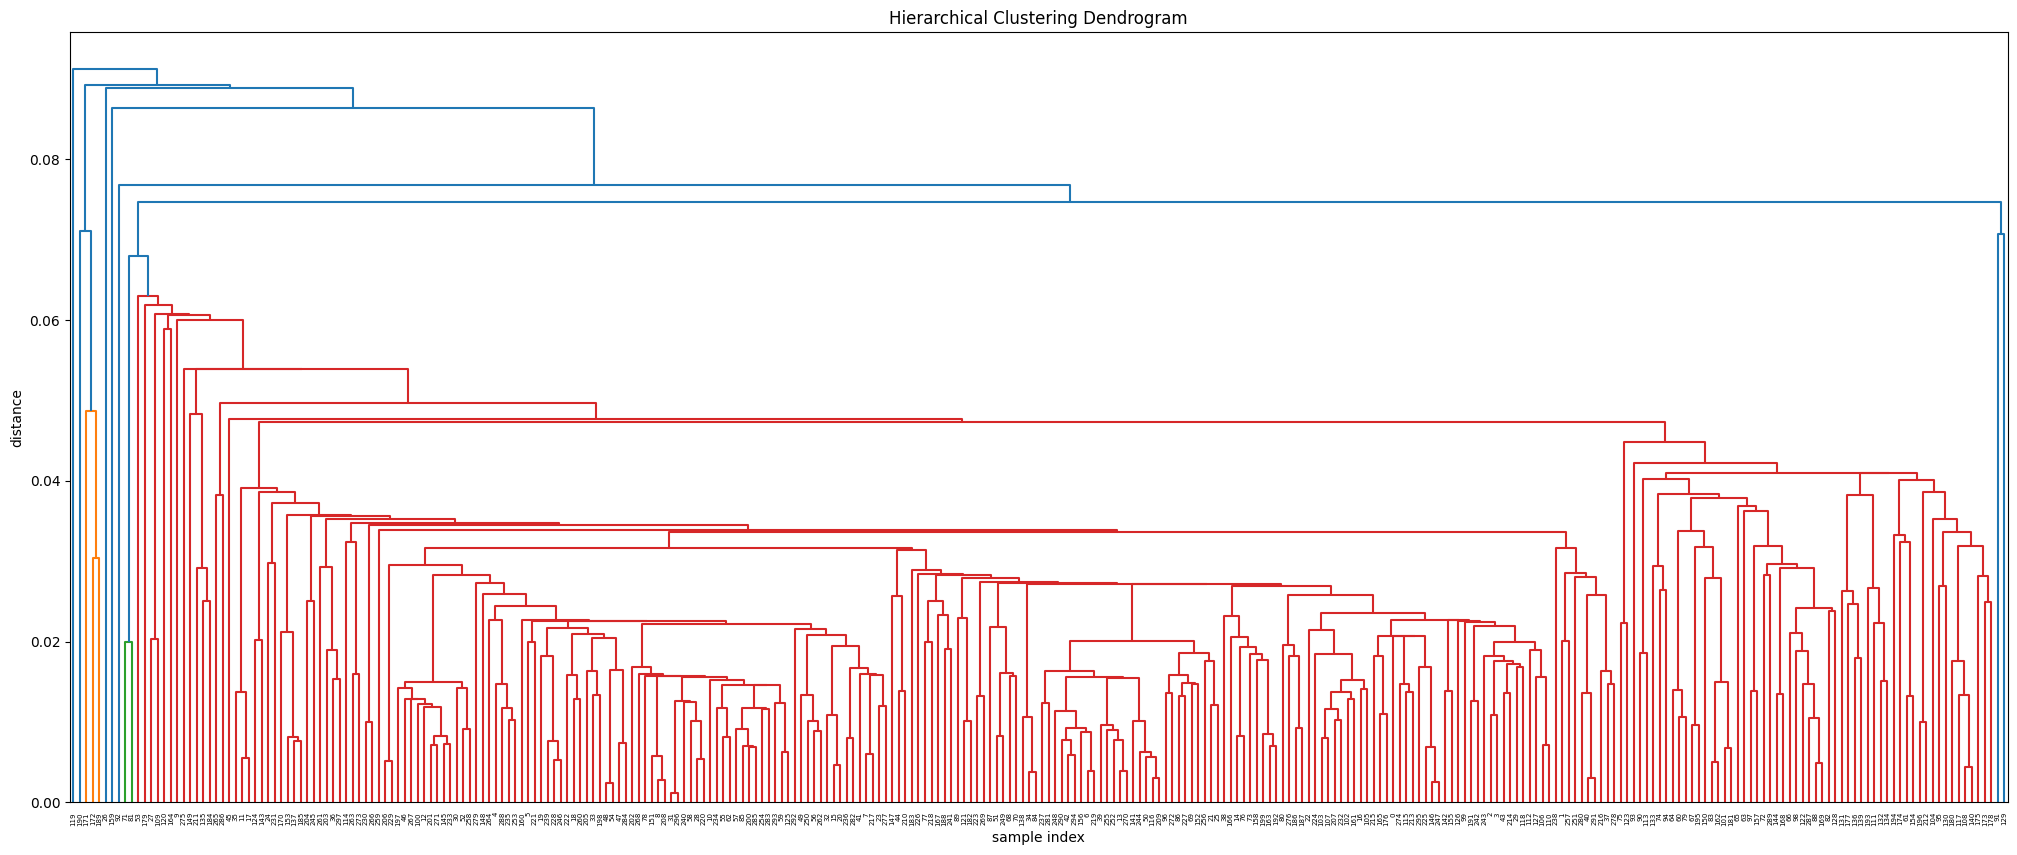

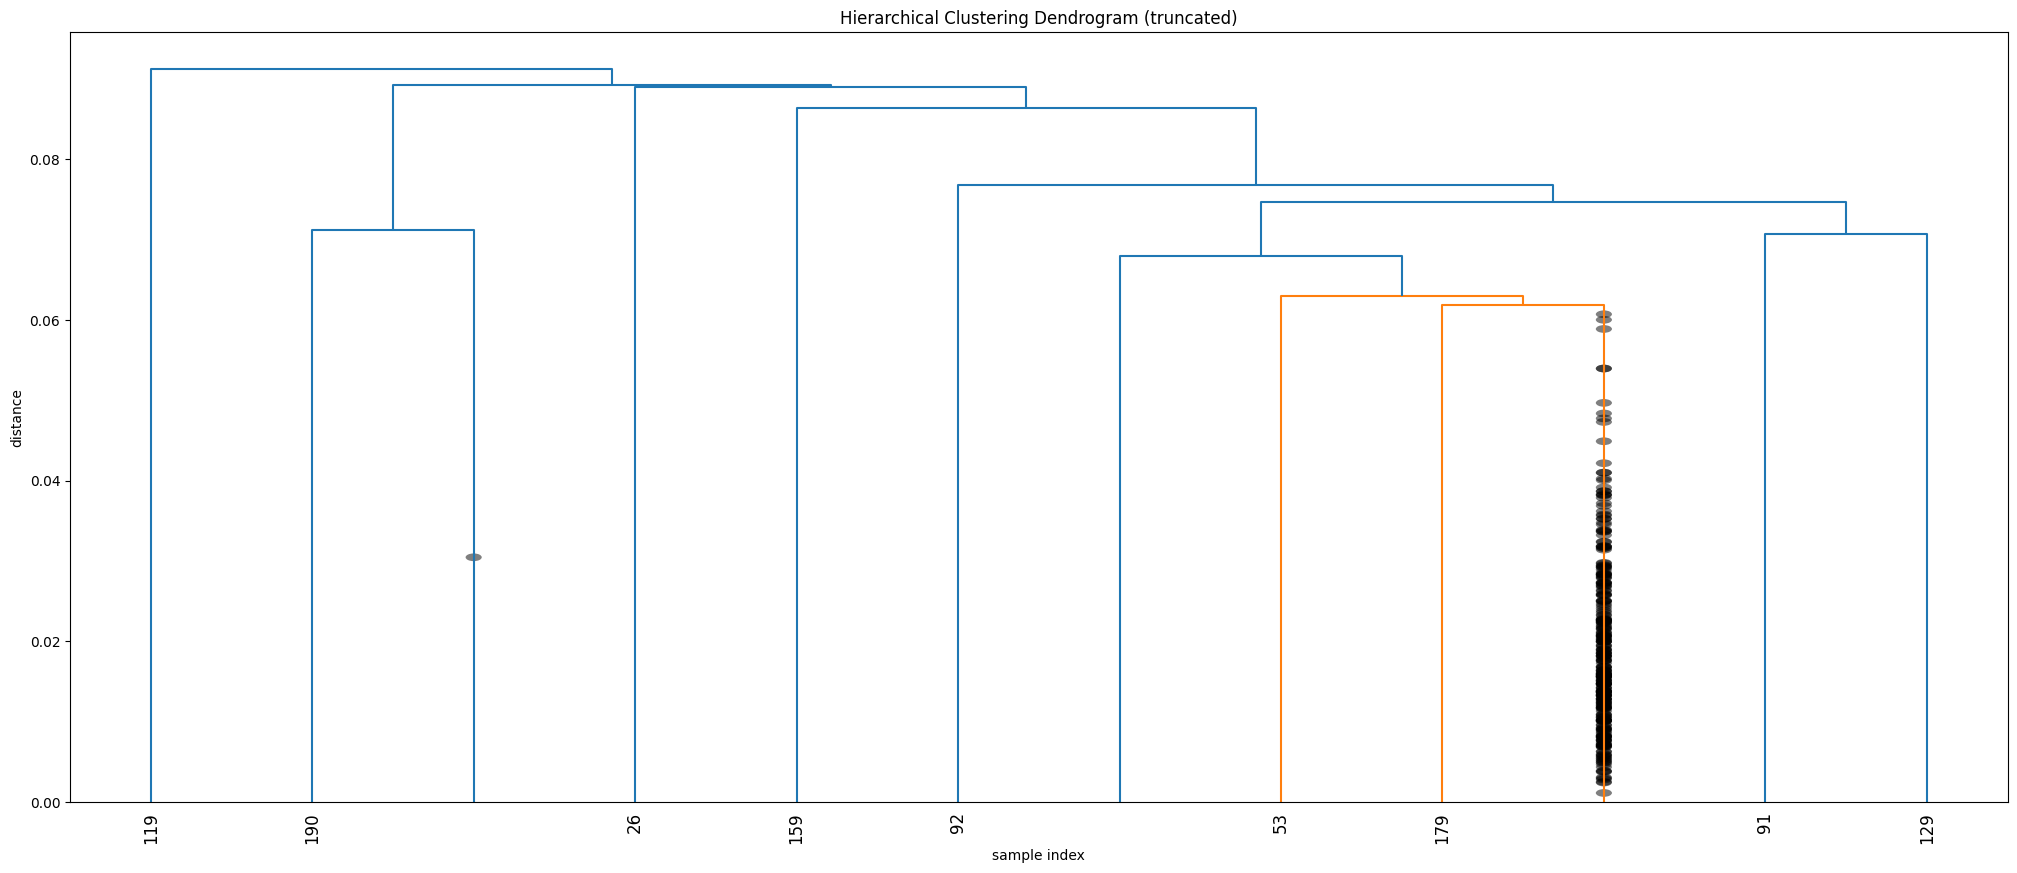

complete
[[ 31.         296.           0.00112203   2.        ]
 [ 48.          54.           0.00241438   2.        ]
 [146.         247.           0.00249686   2.        ]
 [  8.         208.           0.00280528   2.        ]
 [116.         209.           0.00296044   2.        ]
 [ 40.         291.           0.00307445   2.        ]
 [ 34.          84.           0.00372801   2.        ]
 [  6.         219.           0.00383126   2.        ]
 [ 13.         270.           0.00387106   2.        ]
 [108.         140.           0.00433453   2.        ]
 [ 15.          20.           0.00466017   2.        ]
 [ 88.         169.           0.00488055   2.        ]
 [ 83.         162.           0.00496083   2.        ]
 [206.         229.           0.00511782   2.        ]
 [228.         246.           0.00521734   2.        ]
 [ 28.         220.           0.00538705   2.        ]
 [ 11.          17.           0.00548805   2.        ]
 [ 42.         294.           0.0058618    2.        ]
 

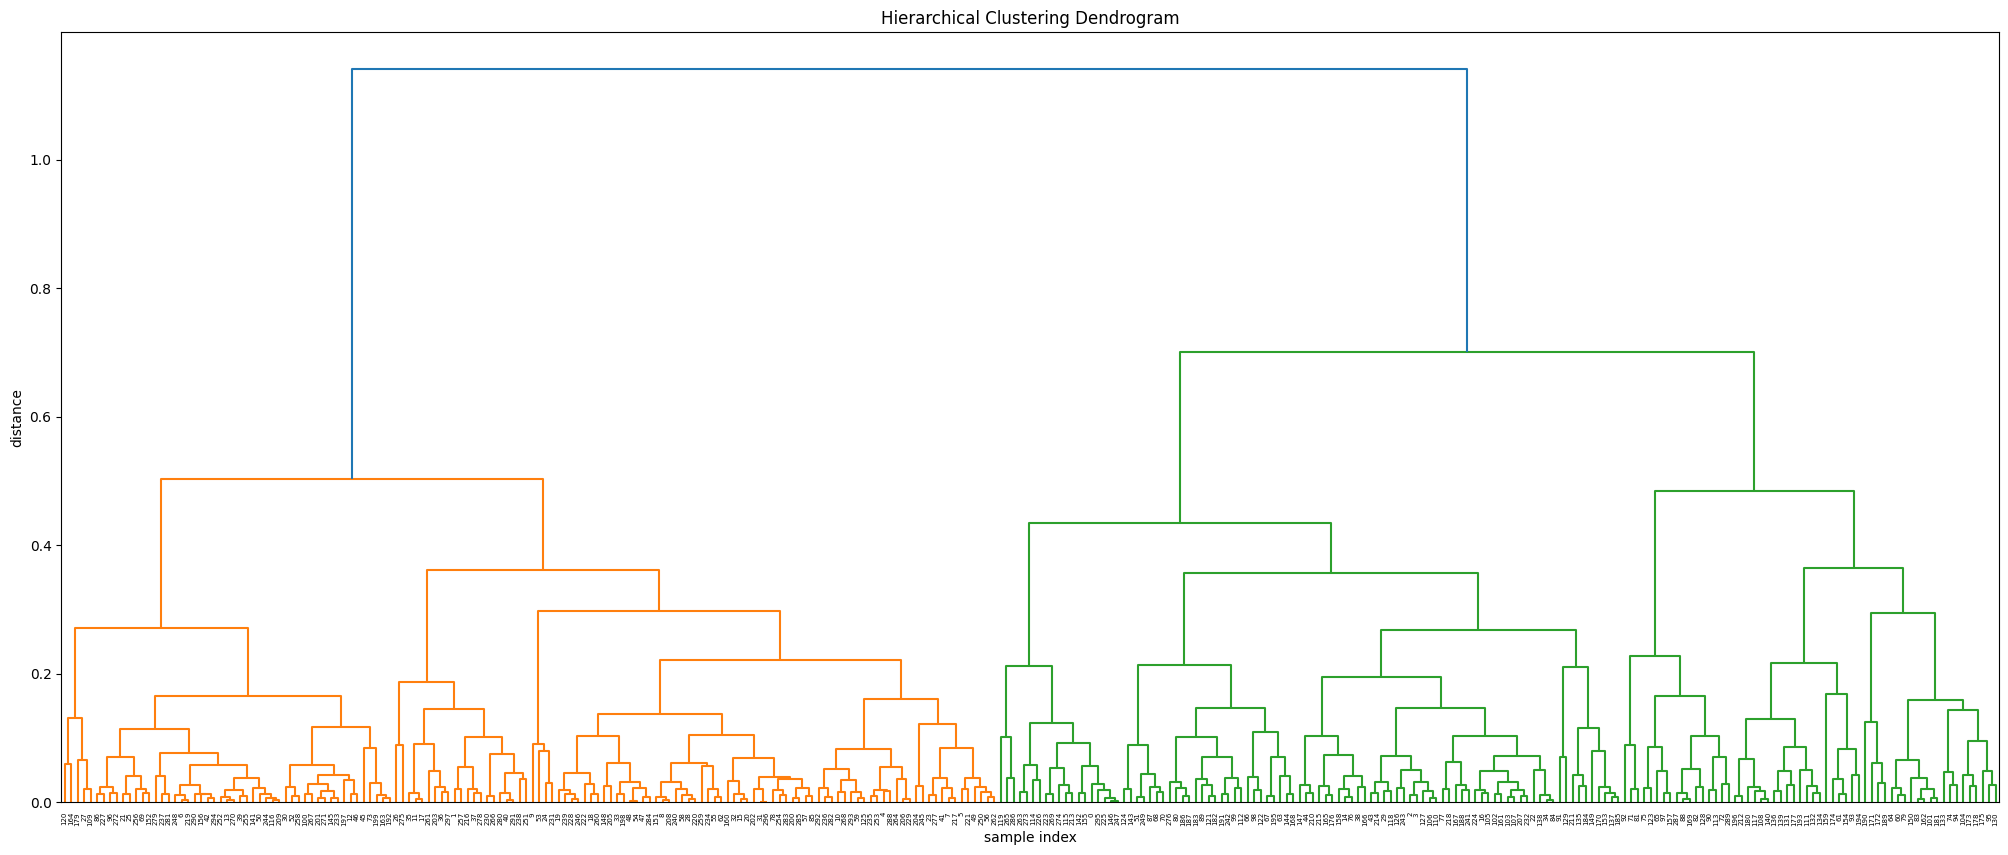

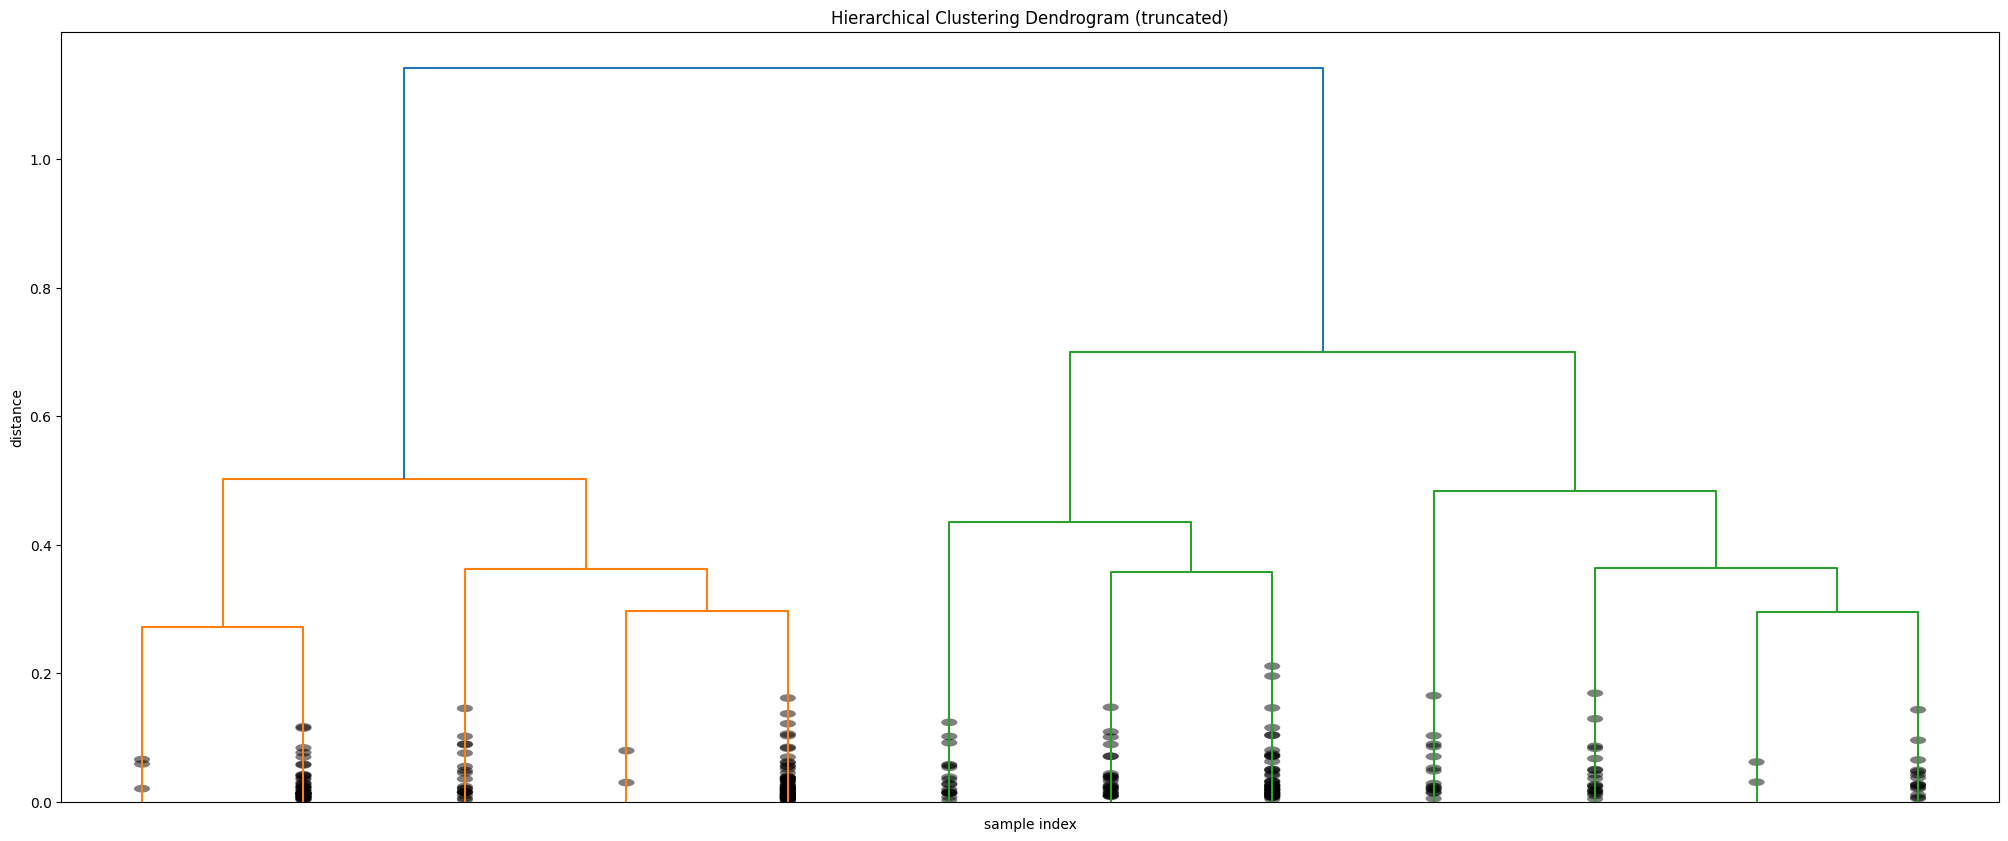

average
[[ 31.         296.           0.00112203   2.        ]
 [ 48.          54.           0.00241438   2.        ]
 [146.         247.           0.00249686   2.        ]
 [  8.         208.           0.00280528   2.        ]
 [116.         209.           0.00296044   2.        ]
 [ 40.         291.           0.00307445   2.        ]
 [ 34.          84.           0.00372801   2.        ]
 [  6.         219.           0.00383126   2.        ]
 [ 13.         270.           0.00387106   2.        ]
 [108.         140.           0.00433453   2.        ]
 [ 15.          20.           0.00466017   2.        ]
 [ 88.         169.           0.00488055   2.        ]
 [ 83.         162.           0.00496083   2.        ]
 [206.         229.           0.00511782   2.        ]
 [228.         246.           0.00521734   2.        ]
 [ 28.         220.           0.00538705   2.        ]
 [ 11.          17.           0.00548805   2.        ]
 [ 42.         294.           0.0058618    2.        ]
 [

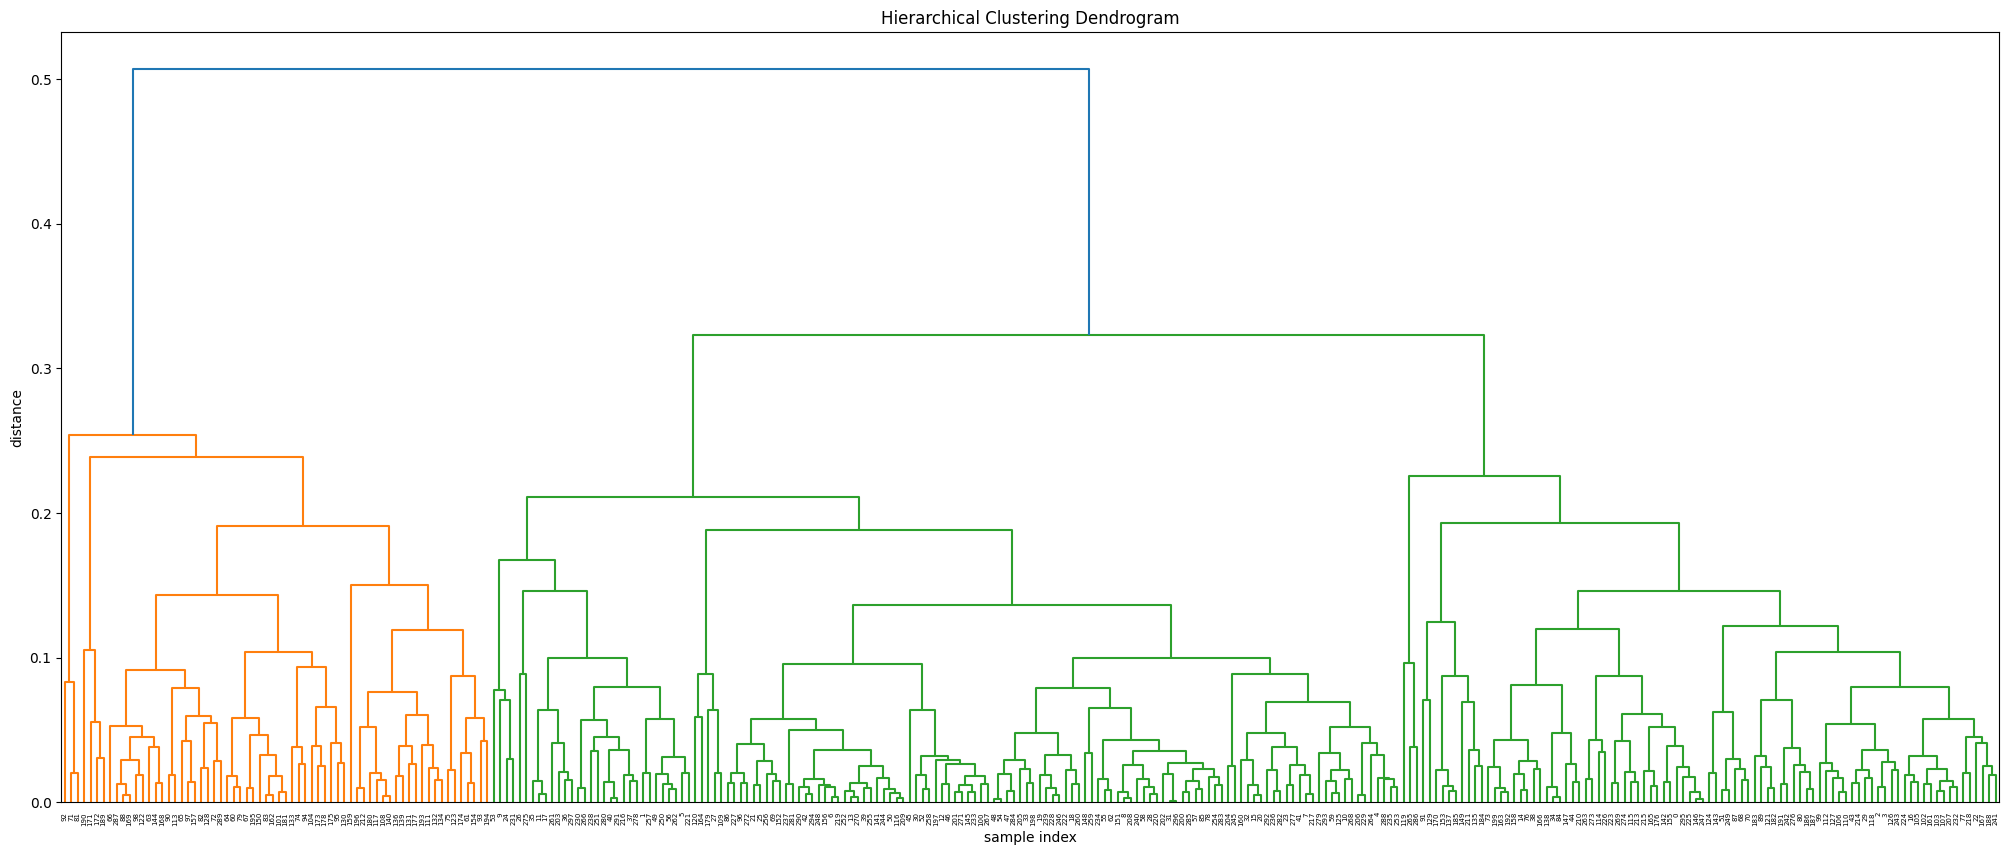

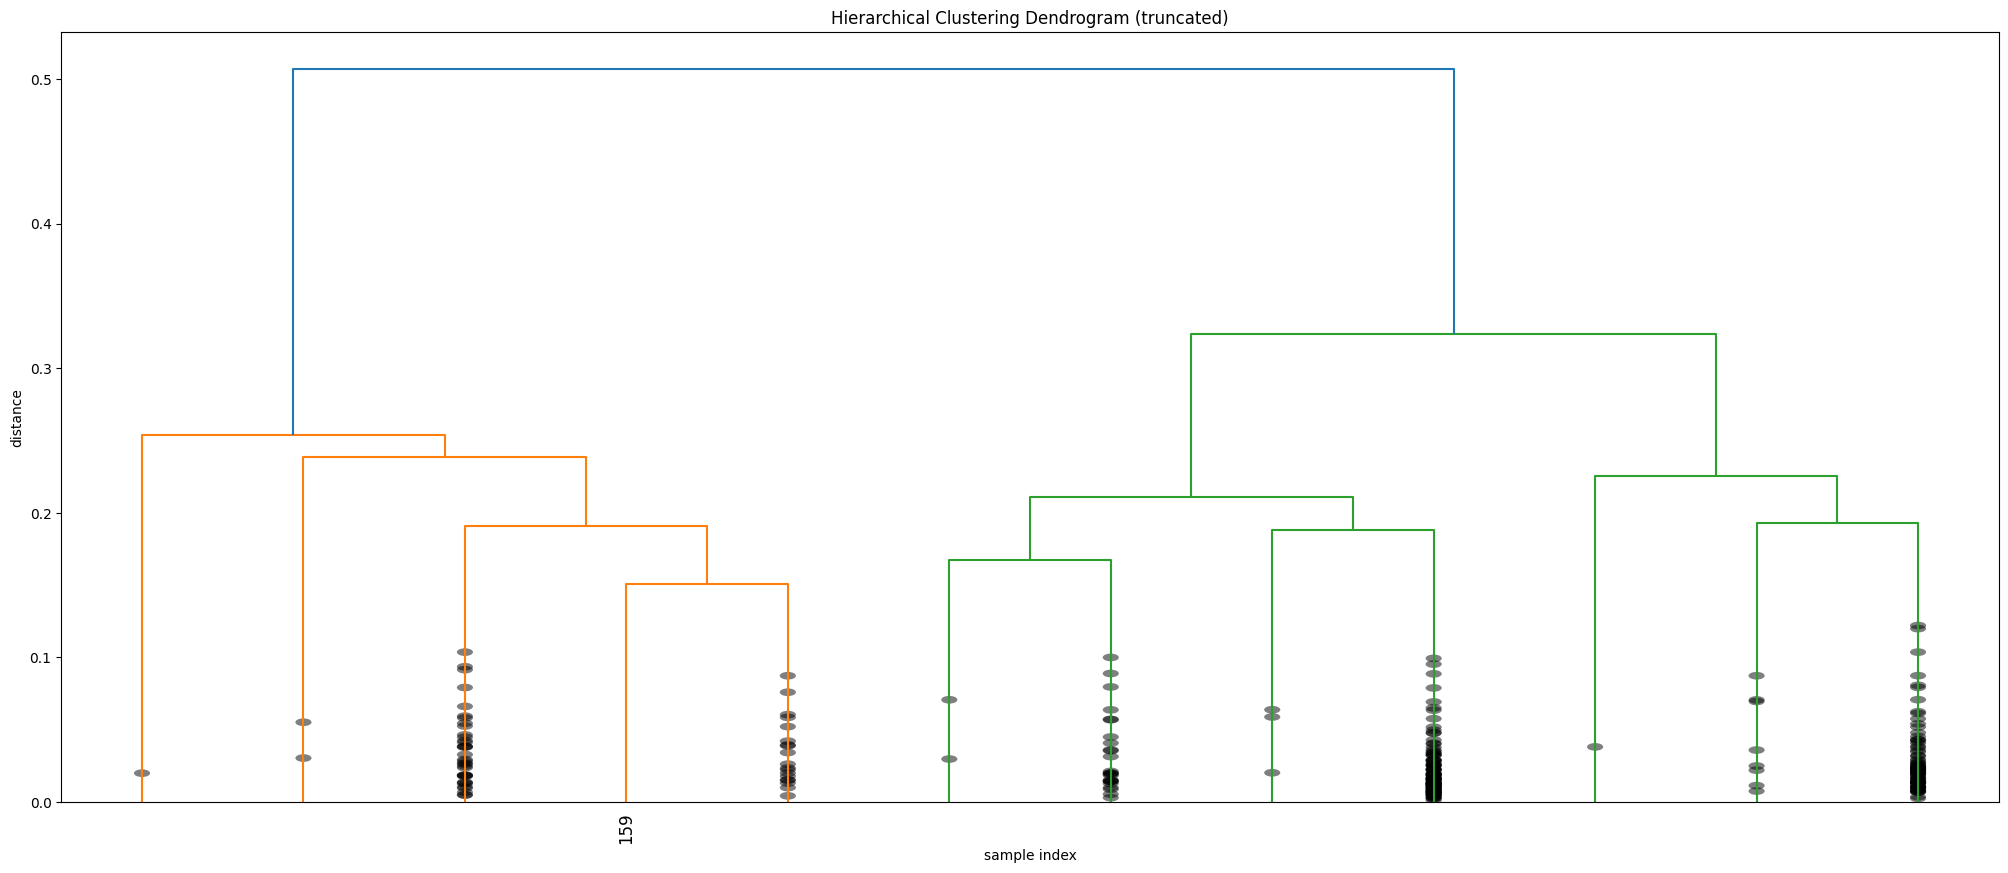

In [377]:
constructClustering(subset_attr)

In [379]:
all_z = all_z[3:]

single
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


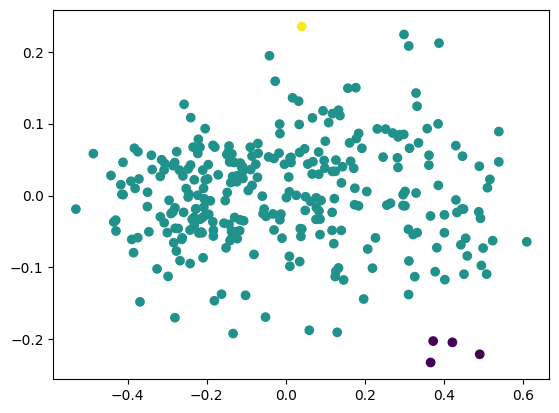

complete
[2 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1 1
 1 2 1 1 1 1 2 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 3 3 1 2 3 3 2 2 2 1 2 3 3 1
 3 3 2 2 1 3 2 3 3 3 2 1 1 2 3 2 3 2 3 3 3 3 1 3 2 2 1 3 2 2 3 2 2 2 3 1 2
 3 2 3 2 2 1 3 2 2 1 2 2 3 2 1 2 2 3 2 3 3 3 3 3 2 3 2 2 3 3 1 2 2 2 1 2 2
 1 2 3 1 1 2 3 2 1 3 2 3 1 2 3 1 1 2 2 2 2 3 2 3 3 3 3 3 2 3 3 1 3 3 2 2 2
 2 2 2 2 3 3 2 1 3 3 2 3 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 3 2 2 2 1 1 2 1 1 1
 1 2 2 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 2 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 2 1 1 1 2 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 2 3 1 3 1 1 1 1 1 2
 1 1]


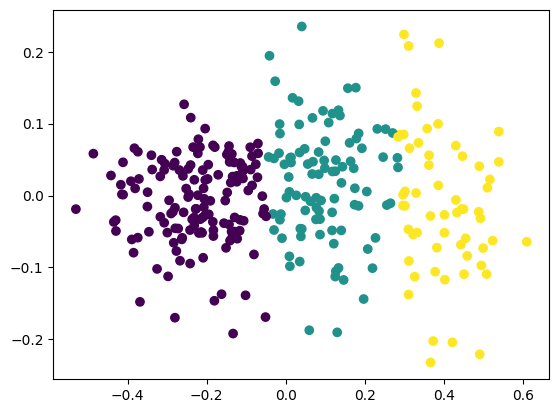

average
[3 2 3 3 2 2 2 2 2 2 2 2 2 2 3 2 3 2 2 2 2 2 3 2 2 2 2 2 2 3 2 2 2 2 3 2 2
 2 3 2 2 2 2 3 3 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 1 1 2 1 1 1 1 1 3 2 3 1 1 3
 1 1 3 3 2 1 3 1 1 1 3 2 2 3 1 3 1 3 1 1 1 1 2 1 1 3 2 1 3 3 1 3 3 3 1 2 3
 1 3 1 3 3 2 1 3 3 2 3 1 1 3 2 3 3 1 3 1 1 1 1 1 3 1 3 3 1 1 2 3 3 1 2 3 3
 2 3 1 2 2 3 1 3 2 1 3 1 2 3 1 3 2 3 3 3 1 1 3 1 1 1 1 1 3 1 1 2 1 1 3 3 3
 3 3 3 3 1 1 3 3 1 1 1 1 2 2 3 2 2 2 2 2 2 2 3 2 2 3 3 1 3 3 3 2 2 3 2 2 2
 2 3 3 3 3 2 2 2 2 2 3 2 2 2 2 2 2 2 2 3 3 3 2 2 2 3 2 3 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 2 3 2 2 2 3 2 2 2 3 3 2 3 2 2 2 2 2 2 2 2 2 3 1 2 1 2 2 2 2 2 3
 2 2]


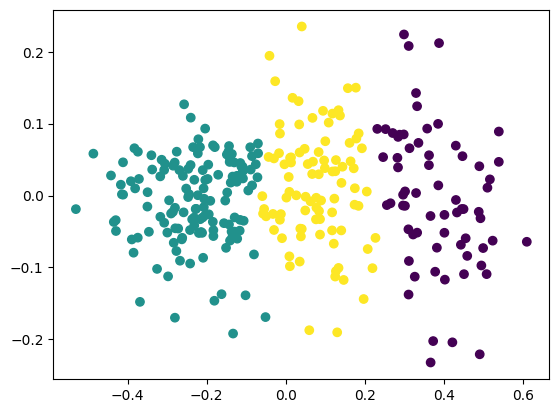

In [380]:
extractClustering(subset_attr.values, 3)

# Compare different clustering solutions with K-means

## Adjusted Rand index (ARI)

The adjusted Rand index (ARI) is a measure of the similarity between two clusterings of a dataset. It takes into account all pairs of samples and whether they are assigned to the same or different clusters in the two clusterings being compared.

In [383]:
single_score = adjusted_rand_score(x_pca['target'], all_labels[0])
complete_score = adjusted_rand_score(x_pca['target'], all_labels[1])
group_avg_score = adjusted_rand_score(x_pca['target'], all_labels[2])
kmean_score = adjusted_rand_score(x_pca['target'], all_labels[3])

subset_single_score = adjusted_rand_score(x_pca['target'], all_labels[4])
subset_complete_score = adjusted_rand_score(x_pca['target'], all_labels[5])
subset_group_avg_score = adjusted_rand_score(x_pca['target'], all_labels[6])

print("Single link: %.3f" % single_score)
print("Complete link: %.3f" % complete_score)
print("Group Average link: %.3f" % group_avg_score)
print("K-means: %.3f" % kmean_score)
print("Subset of attributes Single link: %.3f" % subset_single_score)
print("Subset of attributes Complete link: %.3f" % subset_complete_score)
print("Subset of attributes Group Average link: %.3f" % subset_group_avg_score)

Single link: 0.001
Complete link: 0.124
Group Average link: -0.023
K-means: 0.145
Subset of attributes Single link: -0.013
Subset of attributes Complete link: 0.086
Subset of attributes Group Average link: 0.114


The adjusted_rand_score is a measure of the similarity between two clusterings. The score ranges from -1 to 1, with a score of 1 indicating that the two clusterings are identical, 0 indicating that they are no more similar than would be expected by chance, and negative scores indicating that they are less similar than would be expected by chance.

We start by performing hierarchical clustering on the original dataset using Single, Complete, and Group Average linkage methods. We then perform K-means clustering using the sklearn.cluster KMeans method. We calculate the adjusted_rand_score for each method to evaluate the extent to which the clusters capture the class structure of the dataset. The results are as follows:

Single link: adjusted_rand_score = 0.001
Complete link: adjusted_rand_score = 0.124
Group Average link: adjusted_rand_score = -0.023
K-means: adjusted_rand_score = 0.145
We observe that the K-means clustering method performs better than the hierarchical clustering methods in terms of capturing the class structure of the dataset.

Next, we perform hierarchical clustering on different subsets of attributes from the dataset and compare the results with the original hierarchical clustering results. We choose two subsets of attributes: (`pelvic_incidence` and `sacral_slope`). We perform hierarchical clustering on each subset of attributes using Single, Complete, and Group Average linkage methods. The results are as follows:

Subset of attributes Single link: adjusted_rand_score = -0.013
Subset of attributes Complete link: adjusted_rand_score = 0.086
Subset of attributes Group Average link: adjusted_rand_score = 0.114
We observe that the adjusted_rand_score values for the subset of attributes clustering results are lower than the original hierarchical clustering results. This suggests that using a subset of attributes may not capture the class structure of the dataset as well as using all attributes.

The K-means clustering has the highest adjusted_rand_score of 0.145, indicating that it has the best agreement with the reference clustering. The Complete link clustering also has a relatively high score of 0.124.

The Single link clustering has the lowest score of 0.001, indicating that it has the least agreement with the reference clustering. The Group Average link and Subset of attributes Single link clusterings also have negative scores, indicating that they have less agreement than would be expected by chance.

In conclusion, the K-means clustering method performs better than hierarchical clustering methods in capturing the class structure of the dataset. Additionally, using a subset of attributes may result in lower adjusted_rand_score values and may not capture the class structure of the dataset as well as using all attributes.